In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# There are multiple genres per movie
df = pd.read_csv("dataset/movies_metadata.csv",usecols=['genres', 'overview'])
# Convert genres string type to list
df['genres'] = df['genres'].apply(lambda x: literal_eval(x)).apply(lambda x: sorted([d['name'] for d in x]))
df.head()

print(f"There are {len(df)} rows in the dataset.")

# Some movies have no overview, remove them
print(df['overview'].isnull().sum())
df = df.dropna(subset = ['overview']).reset_index(drop=True)

total_duplicate_titles = sum(df["overview"].duplicated())
print(f"There are {total_duplicate_titles} duplicate titles.")

df = df[~df["overview"].duplicated()]
print(f"There are {len(df)} rows in the deduplicated dataset.")

df['genres_str'] = df['genres'].apply(lambda x: " ".join(str(s) for s in x))

# There are some genres combinations with occurrence as low as 1.
print(sum(df["genres_str"].value_counts() == 1))

# How many unique terms?
print(df["genres_str"].nunique())

# Remove movies with very short overviews
df_filtered = df[df["overview"].apply(lambda x: len(x.split(" "))) > 3]

# Filtering the rare genres combination
df_filtered = df_filtered.groupby("genres_str").filter(lambda x: len(x) > 1)[['overview', 'genres']]
df_filtered.shape

# Remove movies with no genres
df_filtered = df_filtered[df_filtered['genres'].apply(lambda x: len(x)) > 0]

genres = []
for x in df_filtered['genres']:
    if len(x) > 0:
        genres.extend(x)
pd.Series(genres).value_counts()

test_split = 0.2

# Initial train and test split.
train_df, test_df = train_test_split(
    df_filtered,
    test_size=test_split,
    stratify=df_filtered["genres"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

genres = tf.ragged.constant(train_df["genres"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot", num_oov_indices=0)
lookup.adapt(genres)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

sample_label = train_df["genres"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

label_decoded = invert_multi_hot(label_binarized[0])
print(f"Decoded binarized label representation: {label_decoded}")

print(train_df["overview"].apply(lambda x: len(x.split(" "))).describe())

2023-06-14 01:05:21.565517: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-14 01:05:21.646181: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-14 01:05:21.646638: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 01:05:22.850488: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


There are 45466 rows in the dataset.
954
There are 205 duplicate titles.
There are 44307 rows in the deduplicated dataset.
848
1910
Number of rows in training set: 33022
Number of rows in validation set: 4128
Number of rows in test set: 4128


2023-06-14 01:05:26.669888: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-14 01:05:26.670549: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Vocabulary:

['Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Horror', 'Crime', 'Documentary', 'Adventure', 'Science Fiction', 'Family', 'Mystery', 'Fantasy', 'Animation', 'Music', 'Foreign', 'History', 'War', 'Western', 'TV Movie']
Original label: ['Drama', 'History']
Label-binarized representation: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
Decoded binarized label representation: ['Drama' 'History']
count    33022.000000
mean        55.423869
std         34.594403
min          4.000000
25%         28.000000
50%         49.000000
75%         73.000000
max        187.000000
Name: overview, dtype: float64


In [4]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["genres"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["overview"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)


train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

vocabulary = set()
train_df["overview"].str.lower().str.replace('[^\w\s]','').str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

text_vectorizer = layers.TextVectorization(max_tokens=vocabulary_size, ngrams=None, output_mode="tf_idf")
text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

# text_vectorizer = layers.TextVectorization(max_tokens=vocabulary_size, ngrams=None, output_mode="count")

# text_vectorizer = layers.TextVectorization(max_tokens=vocabulary_size, output_sequence_length=max_seqlen, output_mode="int")

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
# with tf.device("/CPU:0"):
#     text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

# train_dataset = train_dataset.map(
#     lambda text, label: (text, label), num_parallel_calls=auto
# ).prefetch(auto)
# validation_dataset = validation_dataset.map(
#     lambda text, label: (text, label), num_parallel_calls=auto
# ).prefetch(auto)
# test_dataset = test_dataset.map(
#     lambda text, label: (text, label), num_parallel_calls=auto
# ).prefetch(auto)

130702


Epoch 1/2
258/258 [==============================] - 17s 61ms/step - loss: 0.2938 - binary_accuracy: 0.8970 - categorical_accuracy: 0.4971 - accuracy: 0.0000e+00 - auc: 0.8016 - f1_score: 0.1846 - precision: 0.5099 - recall: 0.3002 - val_loss: 0.2179 - val_binary_accuracy: 0.9194 - val_categorical_accuracy: 0.5400 - val_accuracy: 0.0000e+00 - val_auc: 0.8904 - val_f1_score: 0.2939 - val_precision: 0.6894 - val_recall: 0.4050
Epoch 2/2
258/258 [==============================] - 15s 58ms/step - loss: 0.1350 - binary_accuracy: 0.9493 - categorical_accuracy: 0.6267 - accuracy: 2.1198e-05 - auc: 0.9628 - f1_score: 0.3951 - precision: 0.8483 - recall: 0.6251 - val_loss: 0.2342 - val_binary_accuracy: 0.9184 - val_categorical_accuracy: 0.5322 - val_accuracy: 1.2112e-05 - val_auc: 0.8873 - val_f1_score: 0.2989 - val_precision: 0.6442 - val_recall: 0.4745


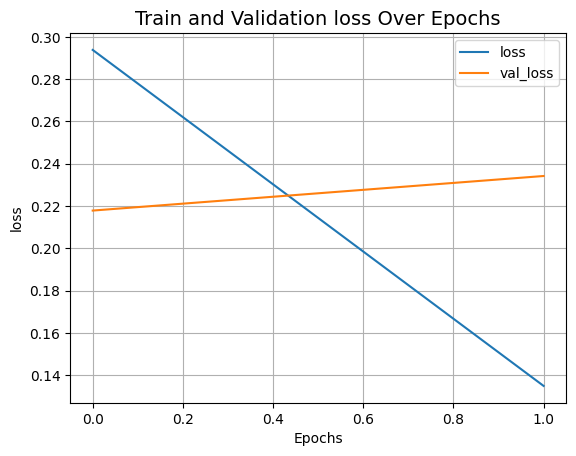

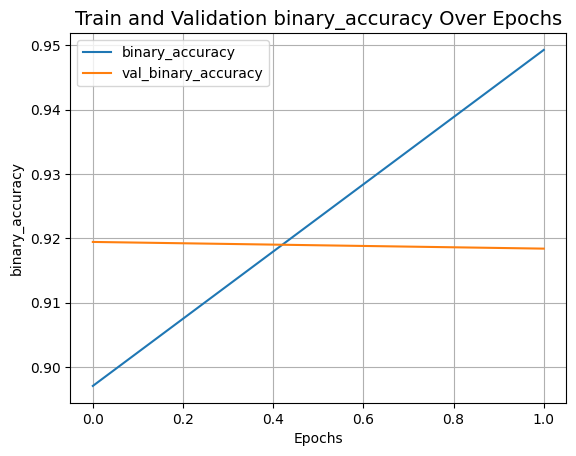

In [5]:
def make_model():
    model = keras.Sequential(
        [
            tf.keras.Input(shape=(1,), dtype=tf.string, name='text'),
            text_vectorizer,
            layers.Dense(64, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]
    )
    return model

epochs = 2

model = make_model()

model.compile(
    loss="binary_crossentropy", 
    optimizer="adam",
    metrics=[tf.keras.metrics.BinaryAccuracy(), 
             tf.keras.metrics.CategoricalAccuracy(), 
             tf.keras.metrics.Accuracy(), 
             tf.keras.metrics.AUC(), 
             tf.keras.metrics.F1Score(average='macro'), 
             tf.keras.metrics.Precision(), 
             tf.keras.metrics.Recall()]
)

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

history = model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[early_stopping_monitor], verbose=1
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

In [185]:
import os

model_dir = "models/"
model_name = "model"
model_version = "1"
model_export_path = f"{model_dir}/{model_name}/{model_version}"

invert_stringlookup_layer = tf.keras.layers.StringLookup(vocabulary=vocab, invert=True)

model_for_inference = keras.Sequential([model, 
                                        layers.Lambda(lambda x: tf.round(x)),
                                        layers.Lambda(lambda x: tf.map_fn(lambda y: tf.where(y == 1.0)[..., 0] + 1, x, dtype=(tf.int64))),
                                        invert_stringlookup_layer
                                        ])

tf.saved_model.save(
    model_for_inference,
    export_dir=model_export_path,
)

print(f"SavedModel files: {os.listdir(model_export_path)}")

INFO:tensorflow:Assets written to: models//model/1/assets


INFO:tensorflow:Assets written to: models//model/1/assets


SavedModel files: ['variables', 'fingerprint.pb', 'assets', 'saved_model.pb']
